In [1]:
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")

import numpy as np
import os
import copy
from astropy.io import fits
import galsim
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import rotate

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/KLens/")
import tfCube
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [16]:
# to make things practical during testing, increase the spaxel size.
pars = tfCube.getParams(redshift = 0.2)
pars['nm_per_pixel'] = 0.033 
pars['expTime'] = 3600.
pars['pixScale'] = 0.1185  # 0.032 arcsec/pixel
pars['Resolution'] = 6000.  # spectroscopic resolution
pars['sini'] = -0.999
pars['aspect'] = 0.2
pars['vcirc'] = 200.
pars['area'] = 3.14*(1000./2.)**2
pars['linelist']['flux'][pars['linelist']['species'] == 'Halpha'] = 6e-24
pars['lambda_min'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] - 2
pars['lambda_max'] = (1 + pars['redshift']) * pars['linelist']['lambda'][pars['linelist']['species'] == 'Halpha'] + 2

lines = pars['linelist']
pars['half_light_radius'] = 0.5
#lines['flux'] = 1e-25
pars['linelist'] = lines
pars['slitAngles'] = np.array([0.])
pars['slitWidth'] = 0.05
# define some fiber parameters
#nfiber = 5
#r_off = 1.5
pars['fiber_size'] = 1.0
pars['psfFWHM'] = .5
pars['vscale'] = 0.5
pars['ngrid'] = 256
pars['image_size'] = 128

In [17]:
c_kms = 2.99792458e5 # c, in km/s
extent =  pars['image_size'] * pars['pixScale']
subGridPixScale = extent*1./pars['ngrid']
grid1d = np.linspace(-extent/2.,extent/2.,pars['ngrid'])
xx,yy = np.meshgrid(grid1d, grid1d)
r = np.sqrt(xx**2 + yy**2)
theta = np.angle(xx+1j*yy)

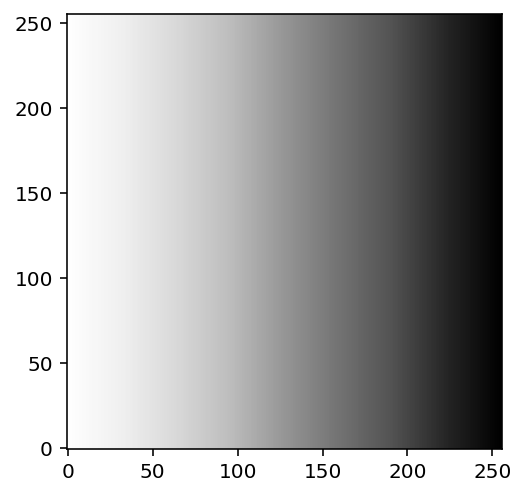

In [18]:
%matplotlib inline
plt.imshow(xx,cmap=plt.cm.Greys,origin="lower")

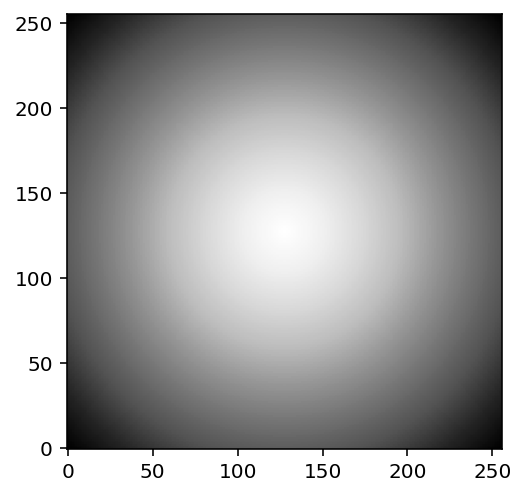

In [19]:
%matplotlib inline
plt.imshow(r,cmap=plt.cm.Greys,origin="lower")

In [20]:
v = pars['vcirc'] * np.arctan(r/pars['vscale']) * (2/ (np.pi * c_kms) )

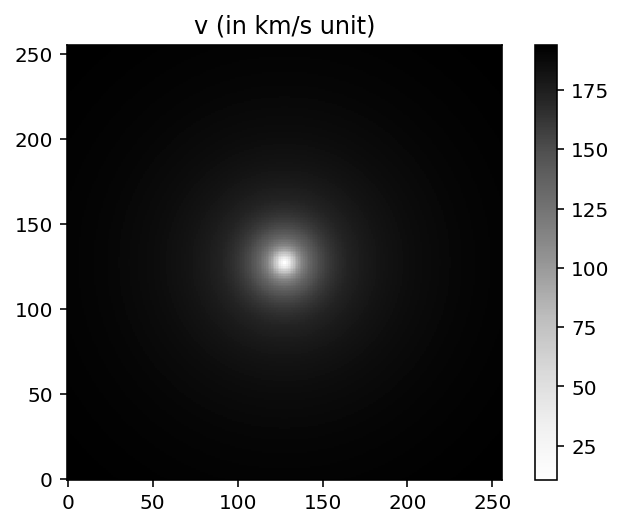

In [21]:
%matplotlib inline
plt.imshow(v*c_kms,cmap=plt.cm.Greys,origin="lower")
plt.title('v (in km/s unit)')
plt.colorbar()

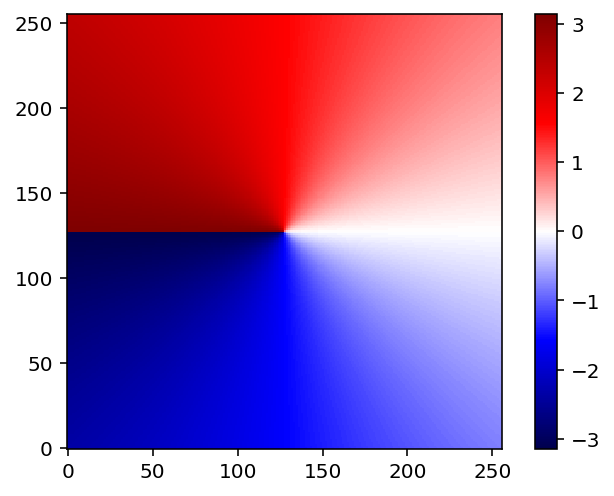

In [22]:
%matplotlib inline
plt.imshow(theta,cmap=plt.cm.seismic,origin="lower",vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# Start

In [23]:
def getPhi(theta, pars=None):
    # This is re-assigning angles in the image plane according to the true inclination of the disk.
    phi = np.arctan(np.tan(theta)/np.sqrt(1 - pars['sini']**2))

    x_orig = np.cos(theta)
    y_orig = np.sin(theta)
    # the arctan function always returns a coordinate in the +x half of the plane.
    x_new = np.cos(phi)
    y_new = np.sin(phi)
    x_new[x_orig < 0] = -x_new[x_orig < 0]
    phi_final = np.angle(x_new+1j*y_new)
    return phi_final


def getPhi_new(theta, pars=None):
    if pars['sini']==1 or pars['sini']==-1:
        phi = np.zeros((pars['ngrid'], pars['ngrid']))
        half_ngrid = int(pars['ngrid']/2)
        phi[:,:half_ngrid] = np.pi
        return phi
    else:
        cosi = np.sqrt(1 - pars['sini']**2)
        phi = np.arctan2(np.sin(theta)/cosi, np.cos(theta))
        return phi

In [24]:
phi_final = getPhi(theta,pars)
cos_phi = np.cos(phi_final)

phi_final_new = getPhi_new(theta,pars)
cos_phi_new = np.cos(phi_final_new)

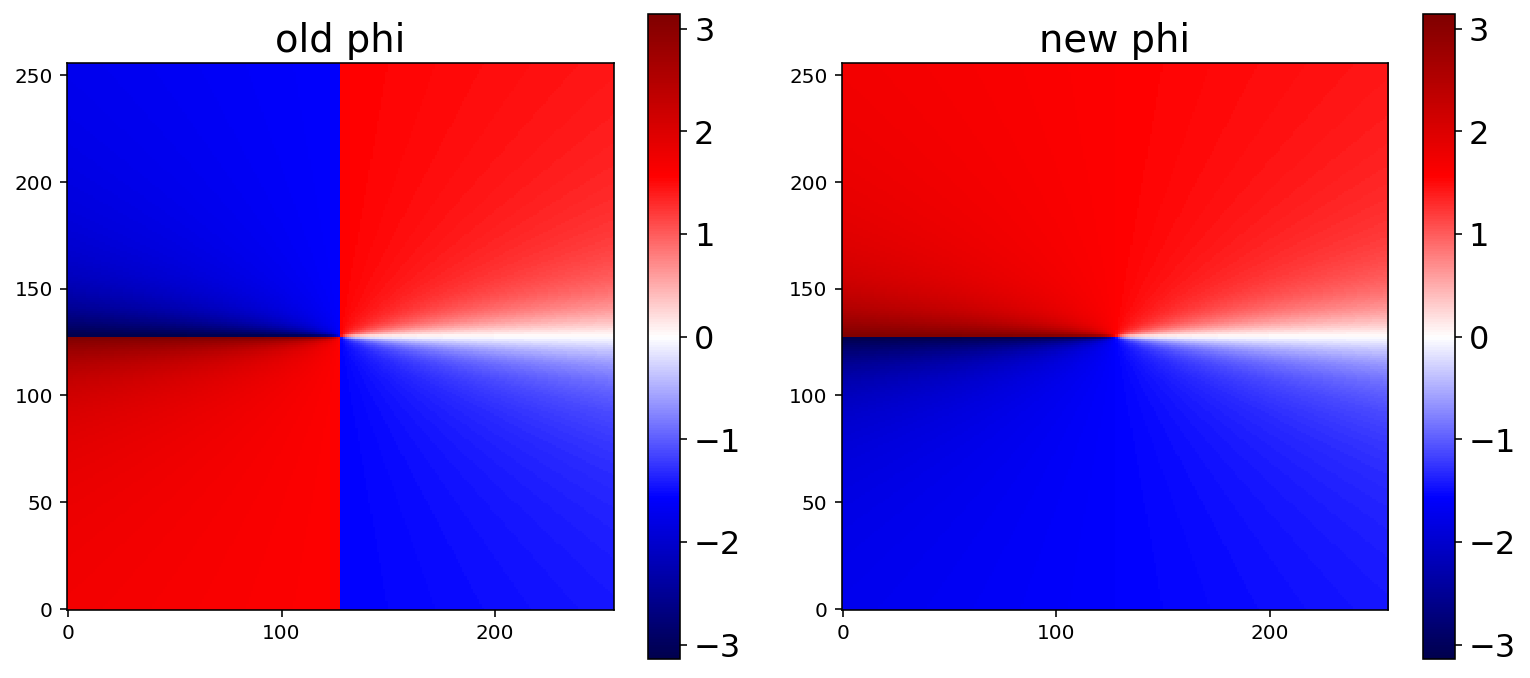

In [25]:
%matplotlib inline

ncol=2

fig,ax = plt.subplots(1,ncol,figsize=(11,5))
plt.rc('font',size=16)

img0 = ax[0].imshow(phi_final,cmap=plt.cm.seismic,origin="lower",vmin=-np.pi, vmax=np.pi)
ax[0].set_title('old phi')
fig.colorbar(img0, ax=ax[0])


img1 = ax[1].imshow(phi_final_new,cmap=plt.cm.seismic,origin="lower",vmin=-np.pi, vmax=np.pi)
ax[1].set_title('new phi')
fig.colorbar(img1, ax=ax[1])

fig.tight_layout()

Using matplotlib backend: MacOSX


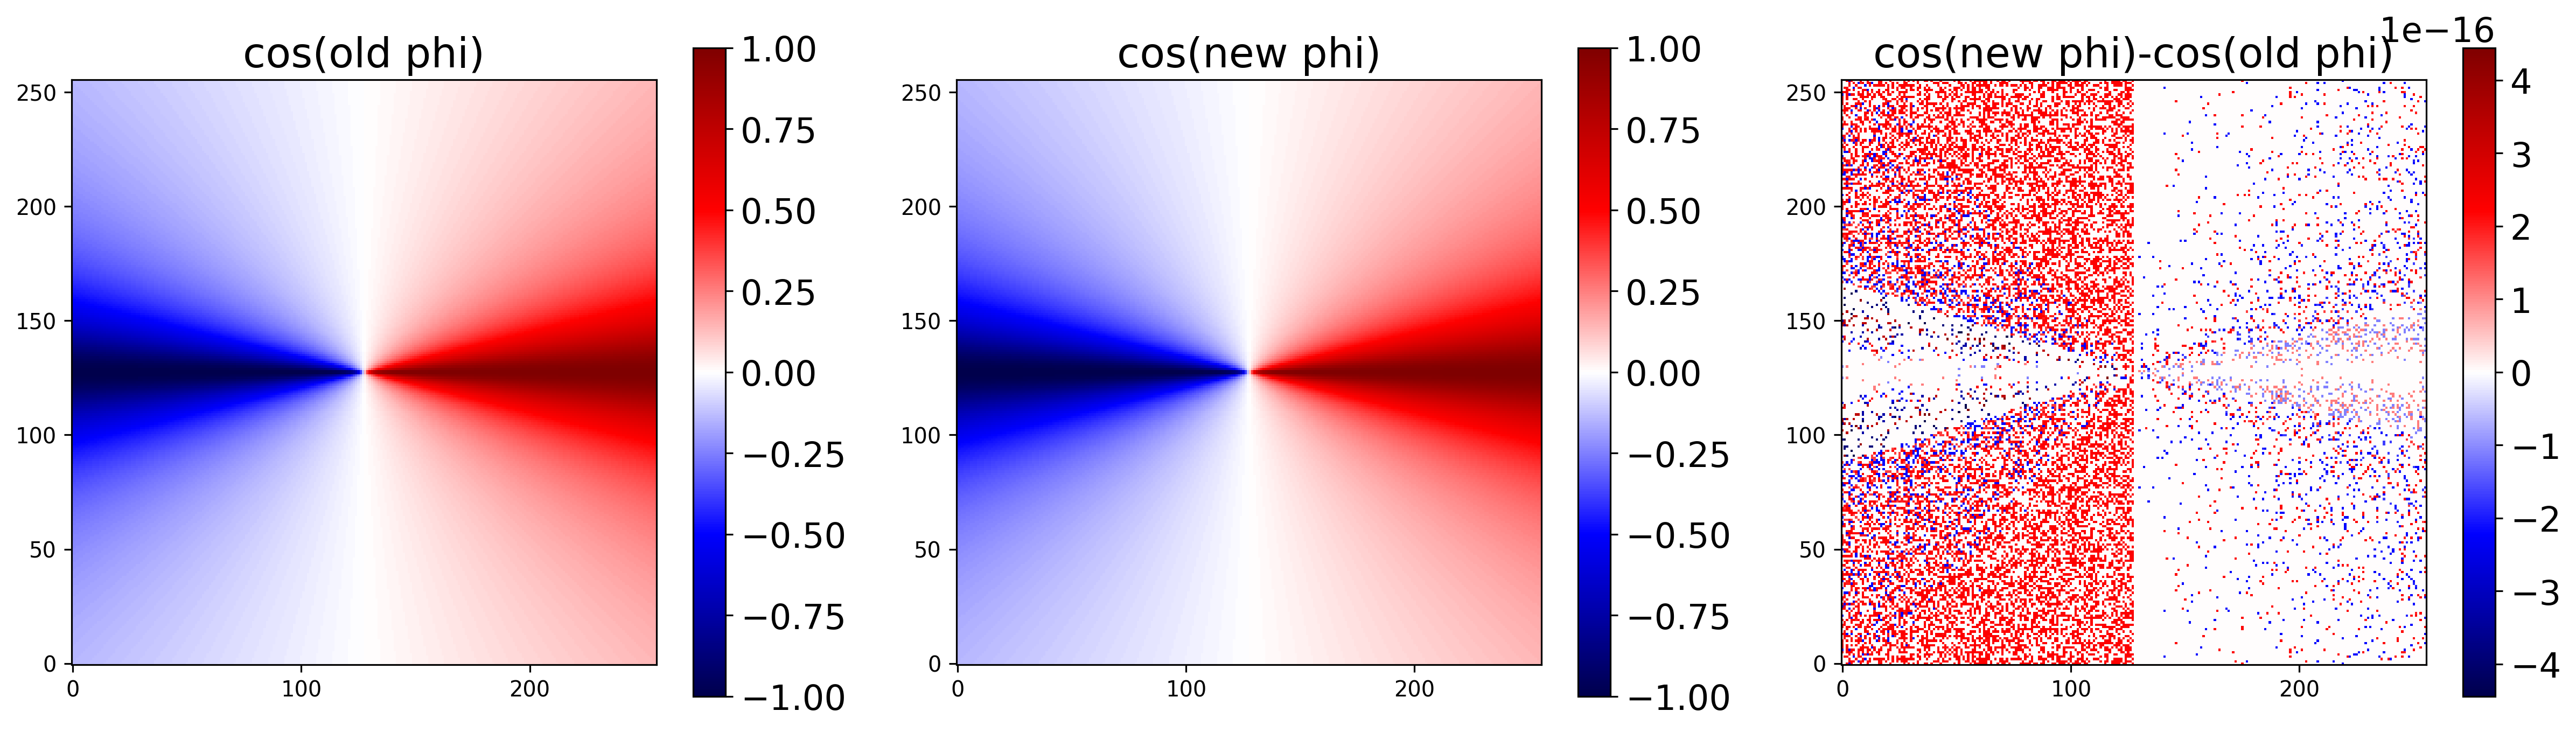

In [26]:
%matplotlib 

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(17,5))
plt.rc('font',size=16)

img0 = ax[0].imshow(cos_phi,cmap=plt.cm.seismic,origin="lower",vmin=-1, vmax=1)
ax[0].set_title('cos(old phi)')
fig.colorbar(img0, ax=ax[0])


img1 = ax[1].imshow(cos_phi_new,cmap=plt.cm.seismic,origin="lower",vmin=-1, vmax=1)
ax[1].set_title('cos(new phi)')
fig.colorbar(img1, ax=ax[1])


diff = cos_phi_new-cos_phi
vmax = np.max(np.abs(diff))
if vmax==0 : vmax=1e-16
img2 = ax[2].imshow(diff,cmap=plt.cm.seismic,origin="lower",vmin=-vmax, vmax=vmax)
fig.colorbar(img2, ax=ax[2])
ax[2].set_title('cos(new phi)-cos(old phi)')

fig.tight_layout()

Using matplotlib backend: MacOSX


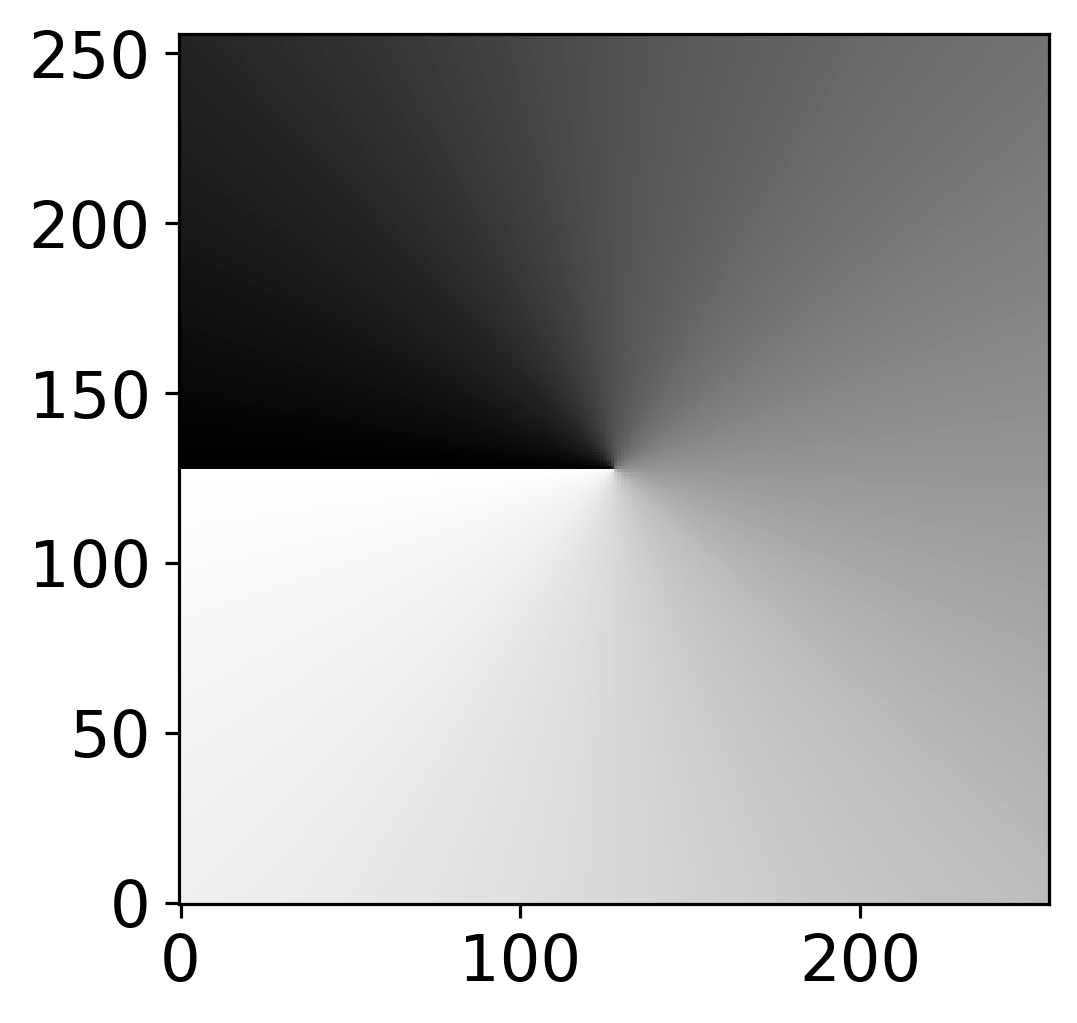

In [13]:
%matplotlib
plt.imshow(theta,cmap=plt.cm.Greys,origin='lower')

Using matplotlib backend: MacOSX


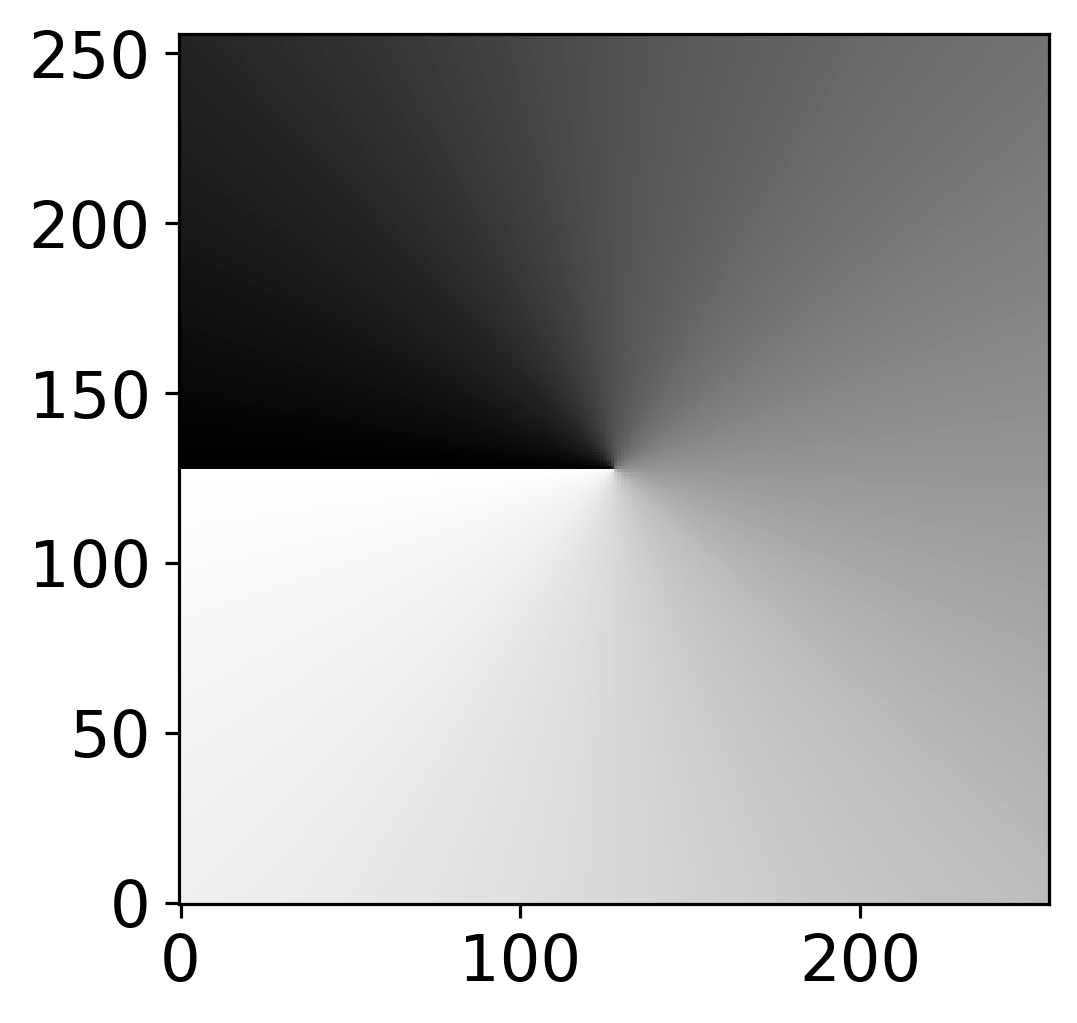

In [14]:
%matplotlib
theta_recover = np.arctan2(np.sin(theta), np.cos(theta))
plt.imshow(theta_recover,cmap=plt.cm.Greys,origin='lower')

In [15]:
%matplotlib
plt.imshow(phi2,cmap=plt.cm.Greys,origin='lower')

Using matplotlib backend: MacOSX


NameError: name 'phi2' is not defined

In [ ]:
%matplotlib
plt.imshow(phi2,cmap=plt.cm.Greys,origin='lower')

In [ ]:
cos_phi2 = np.cos(phi2)
%matplotlib
plt.imshow(cos_phi2,cmap=plt.cm.Greys,origin='lower')